Using limma for key cluster DEG analysis

In [34]:
library(limma)
library(dplyr)
library(ggplot2)
library(edgeR)
library(stringr)
library(reshape2)
library(ggrepel)

In [35]:
# read the voom normalised data
exp_df <- read.csv('/home/nilabjab/cancer_dependency_project_nilabja/cancer_dependency_project/Approach3_Latent_factor/git_repo/Data/Exp.csv', header = T, row.names = 1)    
head(exp_df)

,A1BG,A1BG.AS1,A2M,A4GALT,AAAS,AACS,AADAT,AAGAB,AAK1,AAMDC,⋯,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
127399,1.33585123,2.837184,-0.4757615,3.522372,5.289224,5.436261,1.912285,6.170977,5.486915,5.2589014,⋯,6.255815,7.125433,0.9700382,3.911810,3.513628,3.6713206,5.387186,7.657886,4.690012,5.671180
143B,0.50502144,1.146315,4.0206406,2.191379,5.726666,3.992820,3.975156,6.908841,4.667542,2.9568233,⋯,7.219736,7.134179,1.4876841,4.076379,4.290047,3.9134273,4.413880,7.452491,5.690861,6.489629
170MGBA,-6.34365096,-1.951334,7.9345323,3.568739,4.676171,4.810112,2.668508,6.323091,6.443912,3.2753462,⋯,5.663259,4.028126,2.9669618,4.290252,4.614660,-7.9286135,6.486930,7.582614,6.399150,7.430827
22RV1,-0.05089222,2.802209,2.9740419,-2.257672,6.130935,6.428204,3.251642,6.020554,6.088325,0.6373114,⋯,6.658125,7.350443,1.1318189,3.456761,4.554439,-1.2478247,5.552063,4.451671,5.854928,5.957179
2313287,-4.77226339,-1.602338,-4.7722634,1.264826,5.211839,4.931832,-4.241749,6.394806,5.462554,2.0450756,⋯,6.162984,6.500690,1.9419821,4.451470,4.655631,-3.8547255,5.514551,5.788176,5.886246,6.400234
253J,0.40139481,1.527828,-2.0953405,3.717680,6.460873,5.066240,-4.808059,7.432302,6.160688,2.4514232,⋯,5.223987,6.001888,3.9187273,4.247525,4.068799,0.6909014,4.730023,7.069439,6.007592,5.257582


Using the optuna results

In [36]:
metadata_df <- read.csv('/home/nilabjab/cancer_dependency_project_nilabja/cancer_dependency_project/Approach3_Latent_factor/git_repo/Code/Daporinad_NAMPT_fullres_optuna.csv', 
      header = T, row.names = 1)
head(metadata_df)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X48,X49,X50,actual_dep_NAMPT,actual_IC50,pred_dep_NAMPT,pred_IC50,Set,Benefit_Score,Cluster
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>
CAPAN1,34.86236,12.731788,-28.35657,-6.999353,-81.35644,-102.84732,153.79381,59.630807,145.06561,-14.99298,⋯,-16.975515,-31.96990,8.167136,0.91648277,-2.05510,-0.5057833,-4.3036003,Train,3.7978170,26
COV434,-12.60992,-45.059889,-3.03414,51.632878,-58.03050,-164.07006,118.82984,10.067337,92.57525,48.75552,⋯,-5.406751,-23.64182,58.576286,0.17699862,-7.38299,-0.7788655,-11.0311611,Train,10.2522956,19
HS578T,-17.39350,-86.054662,-33.71569,-2.164938,-81.72579,-144.93178,189.07866,-83.342151,66.31934,59.31882,⋯,11.069185,-91.59704,111.472112,0.41452591,-5.76390,-1.8602740,-2.9448336,Train,1.0845596,25
SKES1,-18.48322,-38.063329,37.20572,44.202261,-66.16367,-126.48162,91.18833,9.300204,122.87067,40.83453,⋯,-20.918483,-87.08690,57.512030,0.35188579,3.10962,-1.2197762,-4.3672283,Train,3.1474521,5
NCIH1299,27.89413,-6.481438,-32.01121,4.711831,-62.39924,-144.68671,148.47705,-27.312003,99.38287,73.13022,⋯,10.058392,-70.54554,57.985269,0.07570761,-3.39070,-1.0183048,-5.3259189,Train,4.3076141,14
NCIH3122,12.09295,-16.189611,-60.18122,6.144246,-69.96150,-84.63031,176.80010,-8.054406,123.39787,31.89142,⋯,-33.489914,-48.92288,21.175617,0.95167012,-4.04509,-1.0061867,-0.6327489,Train,-0.3734378,6


In [37]:
# generate count matrices
exp_df <- t(exp_df)
exp_df <- exp_df[, rownames(metadata_df)]
head(exp_df)

,CAPAN1,COV434,HS578T,SKES1,NCIH1299,NCIH3122,UACC257,RL,SW954,M059K,⋯,SW982,HCC827,OVISE,SUDHL4,A431,OVCAR8,SNU216,LS1034,G402,IGR1
A1BG,-1.8562206,2.739028,3.905400,2.4925674,2.293905,-0.7276981,2.733425,0.978412,1.706095,2.520099,⋯,1.408652,0.9260045,2.094937,3.115999,-1.6339559,2.212848,-1.8061271,-3.43952336,2.373314,2.92597926
A1BG.AS1,0.4329175,2.724359,3.487770,2.7042248,2.480082,1.0100471,2.439898,1.979956,1.506786,3.431108,⋯,2.287275,2.8485301,2.664144,3.674131,0.9068840,3.140918,-0.6713303,-0.08656837,3.186458,2.85078856
A2M,-4.0840265,8.796860,-2.252659,-0.4460321,-3.594595,-3.2146854,5.309477,-2.462602,-6.418027,-1.666202,⋯,3.061000,-4.3193898,-2.405823,-2.307632,-0.3723707,-2.337205,-1.9966490,-0.46323943,-2.777676,4.97369977
A4GALT,2.5096103,2.339716,2.048779,-2.0002978,1.143092,2.7486486,-4.448292,4.497265,4.903338,2.227453,⋯,3.451296,2.2765514,4.866635,4.840720,3.9012726,2.524034,2.8683382,-2.67768310,-1.546896,0.09979608
AAAS,4.8736865,5.947831,5.133701,6.4145766,5.485956,5.3520605,6.151029,6.229993,5.101118,5.325902,⋯,5.709230,4.8580298,5.537557,6.366248,5.2006103,5.946301,4.8447026,6.07900151,5.328392,6.07074491
AACS,5.4096183,6.717107,4.920602,3.9590331,4.630179,5.1049183,4.235979,6.382815,4.819781,4.798833,⋯,4.979115,6.2034533,5.276423,6.694521,5.1610862,5.481613,5.1414571,5.82369480,4.913533,5.95233456


In [38]:
head(metadata_df)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X48,X49,X50,actual_dep_NAMPT,actual_IC50,pred_dep_NAMPT,pred_IC50,Set,Benefit_Score,Cluster
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>
CAPAN1,34.86236,12.731788,-28.35657,-6.999353,-81.35644,-102.84732,153.79381,59.630807,145.06561,-14.99298,⋯,-16.975515,-31.96990,8.167136,0.91648277,-2.05510,-0.5057833,-4.3036003,Train,3.7978170,26
COV434,-12.60992,-45.059889,-3.03414,51.632878,-58.03050,-164.07006,118.82984,10.067337,92.57525,48.75552,⋯,-5.406751,-23.64182,58.576286,0.17699862,-7.38299,-0.7788655,-11.0311611,Train,10.2522956,19
HS578T,-17.39350,-86.054662,-33.71569,-2.164938,-81.72579,-144.93178,189.07866,-83.342151,66.31934,59.31882,⋯,11.069185,-91.59704,111.472112,0.41452591,-5.76390,-1.8602740,-2.9448336,Train,1.0845596,25
SKES1,-18.48322,-38.063329,37.20572,44.202261,-66.16367,-126.48162,91.18833,9.300204,122.87067,40.83453,⋯,-20.918483,-87.08690,57.512030,0.35188579,3.10962,-1.2197762,-4.3672283,Train,3.1474521,5
NCIH1299,27.89413,-6.481438,-32.01121,4.711831,-62.39924,-144.68671,148.47705,-27.312003,99.38287,73.13022,⋯,10.058392,-70.54554,57.985269,0.07570761,-3.39070,-1.0183048,-5.3259189,Train,4.3076141,14
NCIH3122,12.09295,-16.189611,-60.18122,6.144246,-69.96150,-84.63031,176.80010,-8.054406,123.39787,31.89142,⋯,-33.489914,-48.92288,21.175617,0.95167012,-4.04509,-1.0061867,-0.6327489,Train,-0.3734378,6


In [39]:
metadata_df$benefit_score_scaled <- as.numeric(scale(metadata_df$Benefit_Score))

In [40]:
# get clusters 9,29 and 24 as the key_cluster
metadata_df$keyCluster <- ifelse(metadata_df$Cluster %in% c(13,24,15),yes = 'key_cluster', no= 'nonKey_cluster')
metadata_df$keyCluster <- factor(metadata_df$keyCluster, levels = c('nonKey_cluster', 'key_cluster'))

In [41]:
table(metadata_df$keyCluster)


nonKey_cluster    key_cluster 
           588             59 

In [42]:
table(metadata_df$susceptibility_cat)

< table of extent 0 >

In [43]:
sum(is.na(metadata_df$Cluster))

[1] 0

In [44]:
median_score <- median(metadata_df$benefit_score_scaled)
metadata_df$Benefit_Score_cat <- ifelse(metadata_df$benefit_score_scaled >= median_score,
    'high_score', 'low_score')
metadata_df$Benefit_Score_cat <- factor(metadata_df$Benefit_Score_cat, levels = c('low_score', 'high_score'))
# metadata_df$susceptibility_cat <- factor(metadata_df$susceptibility_cat, levels = c('non-key cluster', 'resistant', 'susceptible'))
head(metadata_df)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,actual_dep_NAMPT,actual_IC50,pred_dep_NAMPT,pred_IC50,Set,Benefit_Score,Cluster,benefit_score_scaled,keyCluster,Benefit_Score_cat
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<dbl>,<fct>,<fct>
CAPAN1,34.86236,12.731788,-28.35657,-6.999353,-81.35644,-102.84732,153.79381,59.630807,145.06561,-14.99298,⋯,0.91648277,-2.05510,-0.5057833,-4.3036003,Train,3.7978170,26,0.2048479,nonKey_cluster,high_score
COV434,-12.60992,-45.059889,-3.03414,51.632878,-58.03050,-164.07006,118.82984,10.067337,92.57525,48.75552,⋯,0.17699862,-7.38299,-0.7788655,-11.0311611,Train,10.2522956,19,1.2222331,nonKey_cluster,high_score
HS578T,-17.39350,-86.054662,-33.71569,-2.164938,-81.72579,-144.93178,189.07866,-83.342151,66.31934,59.31882,⋯,0.41452591,-5.76390,-1.8602740,-2.9448336,Train,1.0845596,25,-0.2228284,nonKey_cluster,low_score
SKES1,-18.48322,-38.063329,37.20572,44.202261,-66.16367,-126.48162,91.18833,9.300204,122.87067,40.83453,⋯,0.35188579,3.10962,-1.2197762,-4.3672283,Train,3.1474521,5,0.1023344,nonKey_cluster,high_score
NCIH1299,27.89413,-6.481438,-32.01121,4.711831,-62.39924,-144.68671,148.47705,-27.312003,99.38287,73.13022,⋯,0.07570761,-3.39070,-1.0183048,-5.3259189,Train,4.3076141,14,0.2852045,nonKey_cluster,high_score
NCIH3122,12.09295,-16.189611,-60.18122,6.144246,-69.96150,-84.63031,176.80010,-8.054406,123.39787,31.89142,⋯,0.95167012,-4.04509,-1.0061867,-0.6327489,Train,-0.3734378,6,-0.4526448,nonKey_cluster,low_score


In [45]:
# table(metadata_df$keyCluster, metadata_df$susceptibility_cat)

In [46]:
metadata_df$Cluster <- as.factor(metadata_df$Cluster)
metadata_df$Set <- as.factor(metadata_df$Set)

In [47]:
design_mat <- model.matrix(~ keyCluster + Benefit_Score_cat, data = metadata_df)

In [48]:
dim(design_mat)

[1] 647   3

In [49]:
dim(exp_df)

[1] 16289   647

In [50]:
fit <- lmFit(exp_df, design_mat)
fit2 <- eBayes(fit, trend = TRUE)

In [51]:
topTable(fit2, coef = "keyClusterkey_cluster", number = 10)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
DNAH14,-3.712514,2.2421075,-11.883910,1.340338e-29,2.183276e-25,55.98902
CRY1,-2.009733,4.4841854,-10.886958,1.837192e-25,1.496301e-21,46.75176
KLF11,-2.537320,3.5903505,-10.450715,9.949437e-24,5.402212e-20,42.88277
GPHN,-2.269347,4.0924056,-9.952211,8.282346e-22,3.372778e-18,38.59914
ZNF74,-1.666681,3.7451732,-9.774558,3.857722e-21,1.256769e-17,37.10930
PKP4,-1.002524,6.5226826,-9.587474,1.907868e-20,5.179542e-17,35.56180
ZMYND11,-1.149026,6.1483121,-9.425361,7.484494e-20,1.741642e-16,34.23892
TRIM22,4.181955,1.5247977,9.320867,1.789920e-19,3.644501e-16,33.39522
RANBP17,-4.442595,0.6503027,-9.246351,3.318586e-19,6.006272e-16,32.79793


In [52]:
res <- topTable(fit2, coef = "keyClusterkey_cluster", number = Inf)
res %>%
  filter(abs(logFC) > 1 & adj.P.Val < 0.05) %>%
  dim()

[1] 1373    6

In [53]:
#write.csv(res, file = '/home/nilabjab/cancer_dependency_project_nilabja/cancer_dependency_project/Approach3_Latent_factor/git_repo/Data/Daporinad_NAMPT_depMap_keyCluster_deg_optuna.csv')

In [54]:
#saveRDS(fit2,file = '/home/nilabjab/cancer_dependency_project_nilabja/cancer_dependency_project/Approach3_Latent_factor/git_repo/Data/Daporinad_NAMPT_depMap_keyCluster_deg_fit_optuna.RDS')

In [55]:
df <- res %>%
  filter(!is.na(logFC), !is.na(adj.P.Val))
df$gene <- rownames(df)
# Create a column for significance
df <- df %>%
  mutate(
    sig = case_when(
      adj.P.Val < 0.01 & logFC > 1 ~ "Upregulated",
      adj.P.Val < 0.01 & logFC < -1 ~ "Downregulated",
      TRUE ~ "Non-significant"
    )
  )

# Identify top 10 upregulated and downregulated genes
top_up <- df %>%
  filter(sig == "Upregulated") %>%
  top_n(10, logFC)

top_down <- df %>%
  filter(sig == "Downregulated") %>%
  top_n(-10, logFC)

top_genes <- bind_rows(top_up, top_down)
top_gene_list <- rownames(top_genes)

In [58]:
length(top_gene_list)


[1] 20

In [ ]:
head(df)

,logFC,AveExpr,t,P.Value,adj.P.Val,B,gene,sig
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
DNAH14,-3.712514,2.242108,-11.883910,1.340338e-29,2.183276e-25,55.98902,DNAH14,Downregulated
CRY1,-2.009733,4.484185,-10.886958,1.837192e-25,1.496301e-21,46.75176,CRY1,Downregulated
KLF11,-2.537320,3.590351,-10.450715,9.949437e-24,5.402212e-20,42.88277,KLF11,Downregulated
GPHN,-2.269347,4.092406,-9.952211,8.282346e-22,3.372778e-18,38.59914,GPHN,Downregulated
ZNF74,-1.666681,3.745173,-9.774558,3.857722e-21,1.256769e-17,37.10930,ZNF74,Downregulated
PKP4,-1.002524,6.522683,-9.587474,1.907868e-20,5.179542e-17,35.56180,PKP4,Downregulated


In [ ]:
df['NAMPT', ]

,logFC,AveExpr,t,P.Value,adj.P.Val,B,gene,sig
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
NAMPT,0.1249706,6.966984,0.7565001,0.4496248,0.6393333,-6.25989,NAMPT,Non-significant


EGFR is significantly upregulated among the key clusters, implying its active biological role

In [ ]:
df$gene <- rownames(df)
df$top_gene <- ifelse(df$gene %in% top_gene_list, df$gene, NA)

In [ ]:
P <- ggplot(df, aes(x = logFC, y = -log10(adj.P.Val), color = sig)) +
  geom_point() +
  geom_vline(xintercept = c(-1, 1), linetype = "dashed", color = "black", linewidth = 0.25) +
  geom_hline(yintercept = -log10(0.01), linetype = "dashed", color = "black", linewidth = 0.25) +
  geom_text_repel(
    data = df,
    aes(x = logFC, y = -log10(adj.P.Val), label = top_gene),
    size = 4,
    color = "black",
    box.padding = 0.5,
    max.overlaps = 50
  ) +
  scale_color_manual(
    values = c(
      "Downregulated" = "red",
      "Upregulated" = "green",
      "Non-significant" = "grey"
    ),
    na.value = "grey"  # ensures NA gets grey color
  ) +
  labs(
    title = "Key cluster DEG Analysis",
    x = "log2(Fold Change)",
    y = "-log10(Adjusted p-value)"
  ) +
  theme_minimal(base_size = 12) 

Warning message:
“Removed 16269 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”


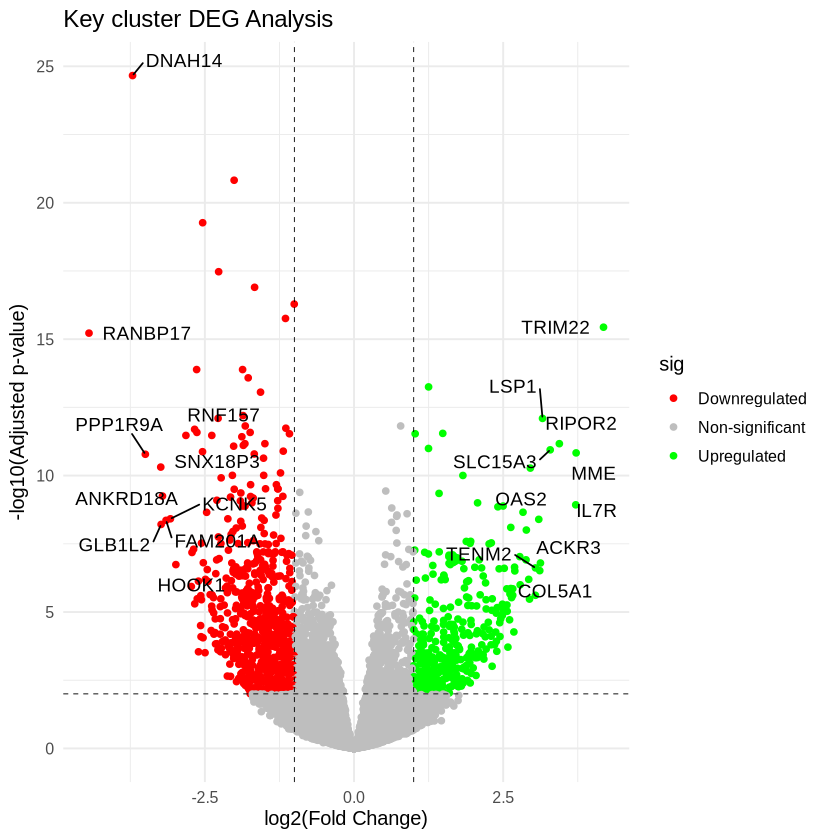

In [ ]:
print(P)

In [ ]:
ggsave(
  plot = P,
  filename = "/home/nilabjab/cancer_dependency_project_nilabja/cancer_dependency_project/Approach3_Latent_factor/git_repo/Figs/Fig5/Daporinad_NAMPT_keyCluster_deg_optuna.pdf",
  width = 8.27,
  height = 11.69,
  units = "in",
  dpi = 600,
  device = cairo_pdf
)


Warning message:
“Removed 16269 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”


In [ ]:

# Identify top 10 upregulated and downregulated genes
top_up <- df %>%
  filter(sig == "Upregulated") %>%
  head(100)

top_down <- df %>%
  filter(sig == "Downregulated") %>%
  head(100)

top_genes <- bind_rows(top_up, top_down)
top_gene_list <- rownames(top_genes)

In [ ]:
writeLines(top_gene_list, con = '/home/nilabjab/cancer_dependency_project_nilabja/cancer_dependency_project/Approach3_Latent_factor/git_repo/Data/Daporinad_NAMPT_depMap_keyCluster_topDEG_optuna.txt')

In [ ]:
write.csv(metadata_df, '/home/nilabjab/cancer_dependency_project_nilabja/cancer_dependency_project/Approach3_Latent_factor/git_repo/Data/Daporinad_NAMPT_fullRes_optuna.csv', row.names=TRUE)

#### Benefit score DEG analysis

In [ ]:
str(fit2)

Formal class 'MArrayLM' [package "limma"] with 1 slot
  ..@ .Data:List of 23
  .. ..$ : num [1:16289, 1:3] 0.557 1.496 -0.678 1.273 5.607 ...
  .. .. ..- attr(*, "dimnames")=List of 2
  .. .. .. ..$ : chr [1:16289] "A1BG" "A1BG.AS1" "A2M" "A4GALT" ...
  .. .. .. ..$ : chr [1:3] "(Intercept)" "keyClusterkey_cluster" "Benefit_Score_cathigh_score"
  .. ..$ : int 3
  .. ..$ : int [1:3] 0 1 2
  .. ..$ :List of 5
  .. .. ..$ qr   : num [1:686, 1:3] -26.1916 0.0382 0.0382 0.0382 0.0382 ...
  .. .. .. ..- attr(*, "dimnames")=List of 2
  .. .. .. .. ..$ : chr [1:686] "22RV1" "2313287" "253J" "253JBV" ...
  .. .. .. .. ..$ : chr [1:3] "(Intercept)" "keyClusterkey_cluster" "Benefit_Score_cathigh_score"
  .. .. .. ..- attr(*, "assign")= int [1:3] 0 1 2
  .. .. .. ..- attr(*, "contrasts")=List of 2
  .. .. .. .. ..$ keyCluster       : chr "contr.treatment"
  .. .. .. .. ..$ Benefit_Score_cat: chr "contr.treatment"
  .. .. ..$ qraux: num [1:3] 1.04 1.01 1.04
  .. .. ..$ pivot: int [1:3] 1 2 3
  .. .

In [ ]:
res <- topTable(fit2, coef = "Benefit_Score_cathigh_score", number = Inf)
res %>%
  filter(abs(logFC) > 1 & adj.P.Val < 0.05) %>%
  dim()

head(res)

[1] 938   6

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SLC4A2,-0.7545892,7.2230569,-12.31535,1.251082e-31,2.037887e-27,60.83241
ZCCHC24,-1.7015602,3.1702278,-11.63995,1.053423e-28,7.365206e-25,54.24360
SLC15A2,1.8095449,0.6344019,11.61410,1.356475e-28,7.365206e-25,53.99633
PPP4R3A,0.4713194,6.2819375,11.45253,6.535546e-28,2.661438e-24,52.45876
PLOD3,-1.0380196,6.4178663,-11.04999,3.080775e-26,1.003655e-22,48.69183
C1orf74,0.7908095,3.2233668,10.91782,1.069488e-25,2.903483e-22,47.47539


In [ ]:
df <- res %>%
  filter(!is.na(logFC), !is.na(adj.P.Val))
df$gene <- rownames(df)
# Create a column for significance
df <- df %>%
  mutate(
    sig = case_when(
      adj.P.Val < 0.01 & logFC > 1 ~ "Upregulated",
      adj.P.Val < 0.01 & logFC < -1 ~ "Downregulated",
      TRUE ~ "Non-significant"
    )
  )

# Identify top 10 upregulated and downregulated genes
top_up <- df %>%
  filter(sig == "Upregulated") %>%
  top_n(10, logFC)

top_down <- df %>%
  filter(sig == "Downregulated") %>%
  top_n(-10, logFC)

top_genes <- bind_rows(top_up, top_down)
top_gene_list <- rownames(top_genes)

In [ ]:
df['EGFR',]

,logFC,AveExpr,t,P.Value,adj.P.Val,B,gene,sig
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
EGFR,-1.257353,5.936978,-4.494723,8.175805e-06,4.972953e-05,3.091591,EGFR,Downregulated


In [ ]:
df$gene <- rownames(df)
df$top_gene <- ifelse(df$gene %in% top_gene_list, df$gene, NA)

In [ ]:
P <- ggplot(df, aes(x = logFC, y = -log10(adj.P.Val), color = sig)) +
  geom_point() +
  geom_vline(xintercept = c(-1, 1), linetype = "dashed", color = "black", linewidth = 0.25) +
  geom_hline(yintercept = -log10(0.01), linetype = "dashed", color = "black", linewidth = 0.25) +
  geom_text_repel(
    data = df,
    aes(x = logFC, y = -log10(adj.P.Val), label = top_gene),
    size = 4,
    color = "black",
    box.padding = 0.5,
    max.overlaps = 50
  ) +
  scale_color_manual(
    values = c(
      "Downregulated" = "red",
      "Upregulated" = "green",
      "Non-significant" = "grey"
    ),
    na.value = "grey"  # ensures NA gets grey color
  ) +
  labs(
    title = "Benefit score DEG Analysis",
    x = "log2(Fold Change)",
    y = "-log10(Adjusted p-value)"
  ) +
  theme_minimal(base_size = 12) 

In [ ]:
ggsave(
  plot = P,
  filename = "/home/sreeramp/cancer_dependency_project/nilabja/Approach3_Latent_factor/git_repo/Figs/benefitScore_depMap_deg_28122025_optuna.pdf",
  width = 8.27,
  height = 11.69,
  units = "in",
  dpi = 600,
  device = cairo_pdf
)


Warning message:
“Removed 16269 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”


Warning message:
“Removed 16269 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”


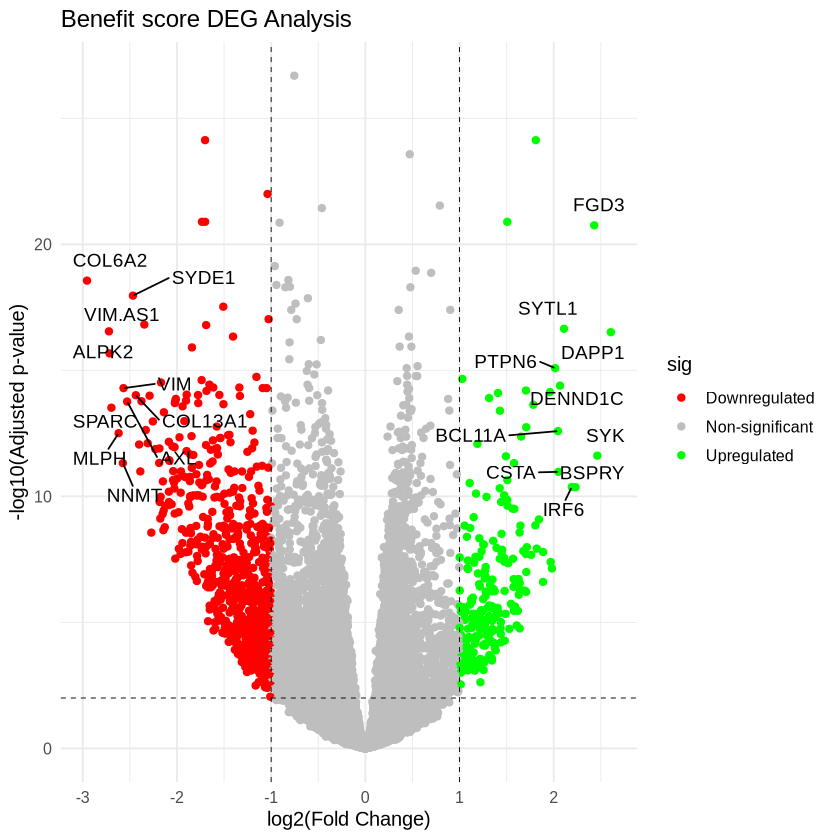

In [ ]:
print(P)

In [ ]:
# Identify top 10 upregulated and downregulated genes
top_up <- df %>%
  filter(sig == "Upregulated") %>%
  head(100)

top_down <- df %>%
  filter(sig == "Downregulated") %>%
  head(100)

top_genes <- bind_rows(top_up, top_down)
top_gene_list <- rownames(top_genes)

writeLines(top_gene_list, con = '/home/sreeramp/cancer_dependency_project/nilabja/Approach3_Latent_factor/git_repo/Data/depMap_benefitScore_topDEG_28122025_optuna.txt')


In [ ]:
write.csv(res, file = '/home/sreeramp/cancer_dependency_project/nilabja/Approach3_Latent_factor/git_repo/Data/depMap_benefitscore_deg_28122025_optuna.csv')